# Hands-on Case Study 1: VM Placement Problem in Cloud Data Center

## 1. Problem Description

🌩️ Cloud computing data centers (a set of 🖥️ physical machines (PMs)) host numerous 💻 virtual machines (VMs) that require ⚡ computing resources such as CPU, memory, and disk storage. 

Efficiently managing these resources while ♻️ minimizing energy consumption is a crucial challenge.

<img src="cloud2.png" width="800" align="center"/>


### 1.1. Objective 🎯

Minimize the total energy consumption of the data center.

### 1.2. Constraints 📌
- Each VM must be assigned to exactly one active PM.
- The total resource usage of VMs on any PM cannot exceed the PM's capacity.
- The number of active PMs should be minimized to reduce energy consumption.
- Binary decision variables indicate whether a VM is allocated to a PM and whether a PM is active.


## 2. Mathematical Model - Binary Linear Program (BLP)

### 2.1. Parameters
Let:
- $I$ be the set of virtual machines (VMs).
- $J$ be the set of physical machines (PMs).
- $r_{i}^{(c)}$, $ r_{i}^{(m)} $, and $ r_{i}^{(d)} $ be the CPU, memory, and disk requirements of VM $ i \in I $.
- $ C_j $, $ M_j $, and $ D_j $ be the CPU, memory, and disk capacity of PM $ j \in J $.
- $ P_j $ be the power consumption of PM $ j $ when active.

### 2.2. Decision Variables
Let:
- $ x_{ij} \in \{0,1\} $ be a binary variable indicating whether VM $ i $ is assigned to PM $ j $.
- $ y_j \in \{0,1\} $ be a binary variable indicating whether PM $ j $ is active or not.

### 2.3. Objective Function  
Minimize the total power consumption:
$$
\begin{align*} 
\min \sum_{j \in J} P_j y_j
\end{align*}
$$

### 2.4. Constraints

**Each VM is assigned to one server**
$$
\begin{align*} 
\sum_{j \in J} x_{ij} = 1, \quad \forall i \in I
\end{align*}
$$

**CPU capacity constraint**
$$
\begin{align*} 
\sum_{i \in I} r_{i}^{(c)} x_{ij} \leq C_j y_j, \quad \forall j \in J
\end{align*}
$$

**Memory capacity constraint**
$$
\begin{align*} 
\sum_{i \in I} r_{i}^{(m)} x_{ij} \leq M_j y_j, \quad \forall j \in J
\end{align*}
$$

**Disk capacity constraint**
$$
\begin{align*} 
\sum_{i \in I} r_{i}^{(d)} x_{ij} \leq D_j y_j, \quad \forall j \in J
\end{align*}
$$

**Binary decision variables**
$$
\begin{align*} 
x_{ij} \in \{0,1\}, \quad y_j \in \{0,1\}, \quad \forall i \in I, j \in J
\end{align*}
$$




## 3. Solving the BLP
In this section, we outline the steps required to implement and solve the BLP model defined above. We will use [Gurobi](https://www.gurobi.com/) as the optimization solver, and to do so, we first need to install the required dependencies.

### 3.1. Installing and Loading Required Packages
To begin, we install and load the necessary packages that will be used throughout the implementation process.

🔍 **Note:** *Gurobi provides a free [academic license](https://www.gurobi.com/academia/academic-program-and-licenses/) for students, researchers, and educators. This license grants access to the full-featured version of Gurobi for academic purposes. To obtain an academic license, users need to register with a valid university email and follow the activation instructions on the Gurobi website. Otherwise, the free license available for non-academic users comes with limitations, such as restricted problem size and performance constraints.*

In [16]:
import subprocess
import sys
# Configure logging to only display CRITICAL level messages or higher
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
# Install and import the required packages
def install_and_import(package, version=None):
    try:
        __import__(package)
    except ImportError:
        if version:
            subprocess.check_call([sys.executable, "-m", "pip", "install", f"{package}=={version}"])
        else:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        __import__(package)

install_and_import("gurobipy", "11.0.3") # Gurobi's optimization package for solving the optimization problem

Then we import the required packages

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

🔍 **Note:** *Before constructing the general solver for the full BLP model, we will first develop a solver to handle a small-scale example of the problem. This step will allow us to gain a clearer understanding of how to formulate and implement the model using Gurobi. By working with a simplified version, we can explore key Gurobi techniques such as defining decision variables, setting up constraints, and optimizing the objective function. This hands-on approach will help build a solid foundation before scaling up to a more complex and generalized implementation.*

### 3.2. Specific Solver - Small-scale Example

#### 3.2.1. Problem Parameters

Consider a small cloud data center with 3 VMs and 2 physical servers.
$I = \{1,2,3\}$, $J = \{1,2\}$

**Virtual Machines (VMs) Resource Requirements**
| VM  | CPU | Memory | Disk |
|-----|-----|--------|------|
| 1   | 2   | 4      | 10   |
| 2   | 3   | 6      | 12   |
| 3   | 1   | 2      | 5    |

**Physical Machines (PMs) Resource Capacities**
| PM | CPU  | Memory | Disk | Power |
|--------|--------|--------|--------|--------|
| 1      | 5           | 10             | 20          | 100|
| 2      | 4           | 8              | 15          | 80 |
 

In [18]:
# Define the data for the VM Placement problem
# A set of 3 VMs with their respective CPU, RAM, and Disk requirements defined above
vms = {
    'VM1': {'CPU': 2, 'RAM': 4, 'Disk': 10},
    'VM2': {'CPU': 3, 'RAM': 6, 'Disk': 12},
    'VM3': {'CPU': 1, 'RAM': 2, 'Disk': 5}
}
# A set of 2 PMs with their respective CPU, RAM, and Disk capacities and Power Consumption defined above
pms = {
    'PM1': {'CPU': 5, 'RAM': 10, 'Disk': 20, 'Power': 100},
    'PM2': {'CPU': 4, 'RAM': 8, 'Disk': 15, 'Power': 80}
}

#### 3.2.2. Define Empty Gurobi Model 

The line `model = gp.Model()` defines a new optimization model (`model`) using Gurobi's Python interface (`gp`). This initializes an empty model object `m`, which will later be populated with decision variables, constraints, and the objective function as the problem formulation progresses. Essentially, it sets up the foundation where all the components of the optimization problem will be added and solved.

In [19]:
# Define the optimization model
model = gp.Model('VM Placement')

#### 3.2.3. Add Decision Variables to the Model 

The decisions for this optimization problem involve:
- Determining for each VM, which PM it should be placed on
- Determining which PMs should be used

Let $x_{ij}\in \{0,1\}$ is a binary variable that is equal to 1 if VM $i$ is placed on PM $j$, and 0 otherwise, $\forall \in I, j \in J$. `x[i, j]`

Let $y_j\in \{0,1\}$ is a binary variable that is equal to 1 if PM $j$ is used, and 0 otherwise, $\forall j \in J$. `y[j]`

In [22]:
# Define the decision variables
# x[i, j] is a binary variable that is equal to 1 if VM i is placed on PM j, and 0 otherwise
x = model.addVars(vms, pms, vtype=GRB.BINARY, name='x')
# y[j] is a binary variable that is equal to 1 if PM j is used, and 0 otherwise
y = model.addVars(pms, vtype=GRB.BINARY, name='y')

#### 3.2.4. Add Objective Function to the Model 

Minimize the total power consumption:
$$
\begin{align*} 
\min \sum_{j \in J} P_j y_j
\end{align*}
$$


In [23]:
# Define the objective function
# Minimize the total power consumption
model.setObjective(gp.quicksum(y[j] * pms[j]['Power'] for j in pms), GRB.MINIMIZE)

### 3.2.5. Add Constraints to the Model 
- Each VM must be assigned to exactly one active PM.
- The total resource usage of VMs on any PM cannot exceed the PM's capacity.
- The number of active PMs should be minimized to reduce energy consumption.
- Binary decision variables indicate whether a VM is allocated to a PM and whether a PM is active.


#### 3.2.5.1. VM-PM Exclusive Placement
Each VM must be placed on exactly one PM

In [24]:
# Each VM must be placed on exactly one PM
model.addConstrs((gp.quicksum(x[i, j] for j in pms) == 1 for i in vms), name='VM')
model.update()

#### 3.2.5.2. CPU requiremennts vs capacities
The sum of the CPU requirements of the VMs placed on a PM should not exceed the CPU PM's capacities

In [25]:
# The sum of the CPU requirements of the VMs placed on a PM should not exceed the CPU PM's capacities
model.addConstrs((gp.quicksum(vms[i]['CPU'] * x[i, j] for i in vms) <= pms[j]['CPU'] * y[j] for j in pms), name='CPU')
model.update()

#### 3.2.5.3. RAM requiremennts vs capacities
The sum of the RAM requirements of the VMs placed on a PM should not exceed the RAM PM's capacities

In [26]:
# The sum of the RAM requirements of the VMs placed on a PM should not exceed the RAM PM's capacities
model.addConstrs((gp.quicksum(vms[i]['RAM'] * x[i, j] for i in vms) <= pms[j]['RAM'] * y[j] for j in pms), name='RAM')
model.update()

#### 3.2.5.4. Disks requiremennts vs capacities
The sum of the Disk requirements of the VMs placed on a PM should not exceed the Disk PM's capacities

In [27]:
# The sum of the Disk requirements of the VMs placed on a PM should not exceed the Disk PM's capacities
model.addConstrs((gp.quicksum(vms[i]['Disk'] * x[i, j] for i in vms) <= pms[j]['Disk'] * y[j] for j in pms), name='Disk')
model.update()

### 3.2.6. Solving the Optimization Model and Output (Solution) Analysis

With the model now set, we can optimize for minimal power consumption. 

#### 3.2.6.1. Solving the Model

Solve the optimization problem using `optimize` function.

In [28]:
# Write the model to a file
model.write("VM_Placement_Small.lp")
# Optimize the model
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 9 rows, 24 columns and 30 nonzeros
Model fingerprint: 0xf3b5fd9b
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [8e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 180.0000000
Presolve removed 9 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 10 available processors)

Solution count 1: 180 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.800000000000e+02, best bound 1.800000000000e+02, gap 0.0000%


#### 3.2.6.2. Print the optimal solution

Now, we can print the optimal solution and visualize the placement of VMs on PMs

The optimal solution has total power consumption: 180.0
PM PM1 is used with power consumption 100
VM VM1 is placed on PM PM1
VM VM3 is placed on PM PM1
PM PM2 is used with power consumption 80
VM VM2 is placed on PM PM2


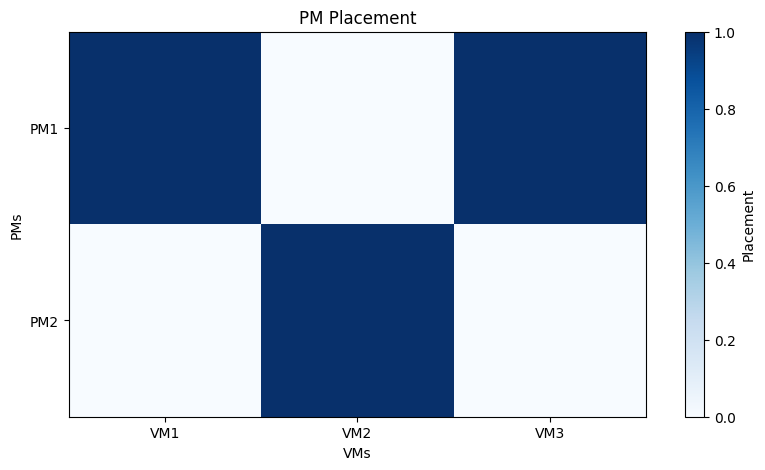

In [29]:
# Print the optimal solution
if model.status == GRB.OPTIMAL:
    print('The optimal solution has total power consumption:', model.objVal)
    for j in pms:
        if y[j].x > 0.5:
            print(f'PM {j} is used with power consumption {pms[j]["Power"]}')
            for i in vms:
                if x[i, j].x > 0.5:
                    print(f'VM {i} is placed on PM {j}')
    # Visualize the optimal solution
    # Create a DataFrame to store the placement of VMs on PMs
    placement = pd.DataFrame(0, index=pms, columns=vms)
    for i in vms:
        for j in pms:
            placement.at[j, i] = x[i, j].x

    plt.figure(figsize=(10, 5))
    plt.imshow(placement, cmap='Blues', interpolation='nearest')
    plt.xticks(range(len(vms)), vms.keys())
    plt.yticks(range(len(pms)), pms.keys())
    plt.xlabel('VMs')
    plt.ylabel('PMs')
    plt.title('PM Placement')
    plt.colorbar(label='Placement')
    plt.show()

    # Save the optimal solution to a CSV file
    placement.to_csv('VM_Placement_Small.csv')
else:
    print('No solution found')



### 3.3. General Solver - Example with Random Data

In this second example, we will solve a larger VM Placement problem with 50 VMs and 20 PMs. 
Data will be generated randomly for this problem.

🤔 **Reflection**

📂 **Data Sources:** Data can be read from a CSV file or a database.

🧠 **Prediction Model:** A machine learning model (e.g., time series forecasting, regression, or deep learning) can be used to predict future demand for VMs and PMs based on:

📊 Historical usage patterns

📈 Workload fluctuations

🌍 External factors

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.3.0 24D70)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 110 rows, 1020 columns and 4060 nonzeros
Model fingerprint: 0x728672ea
Variable types: 0 continuous, 1020 integer (1020 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 2903.0000000
Presolve time: 0.01s
Presolved: 110 rows, 1020 columns, 4060 nonzeros
Variable types: 0 continuous, 1020 integer (1020 binary)

Root relaxation: objective 1.061047e+03, 660 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1061.04688    0   37 2903.00000 1061.04688  63.4%     -    0s
H    0   

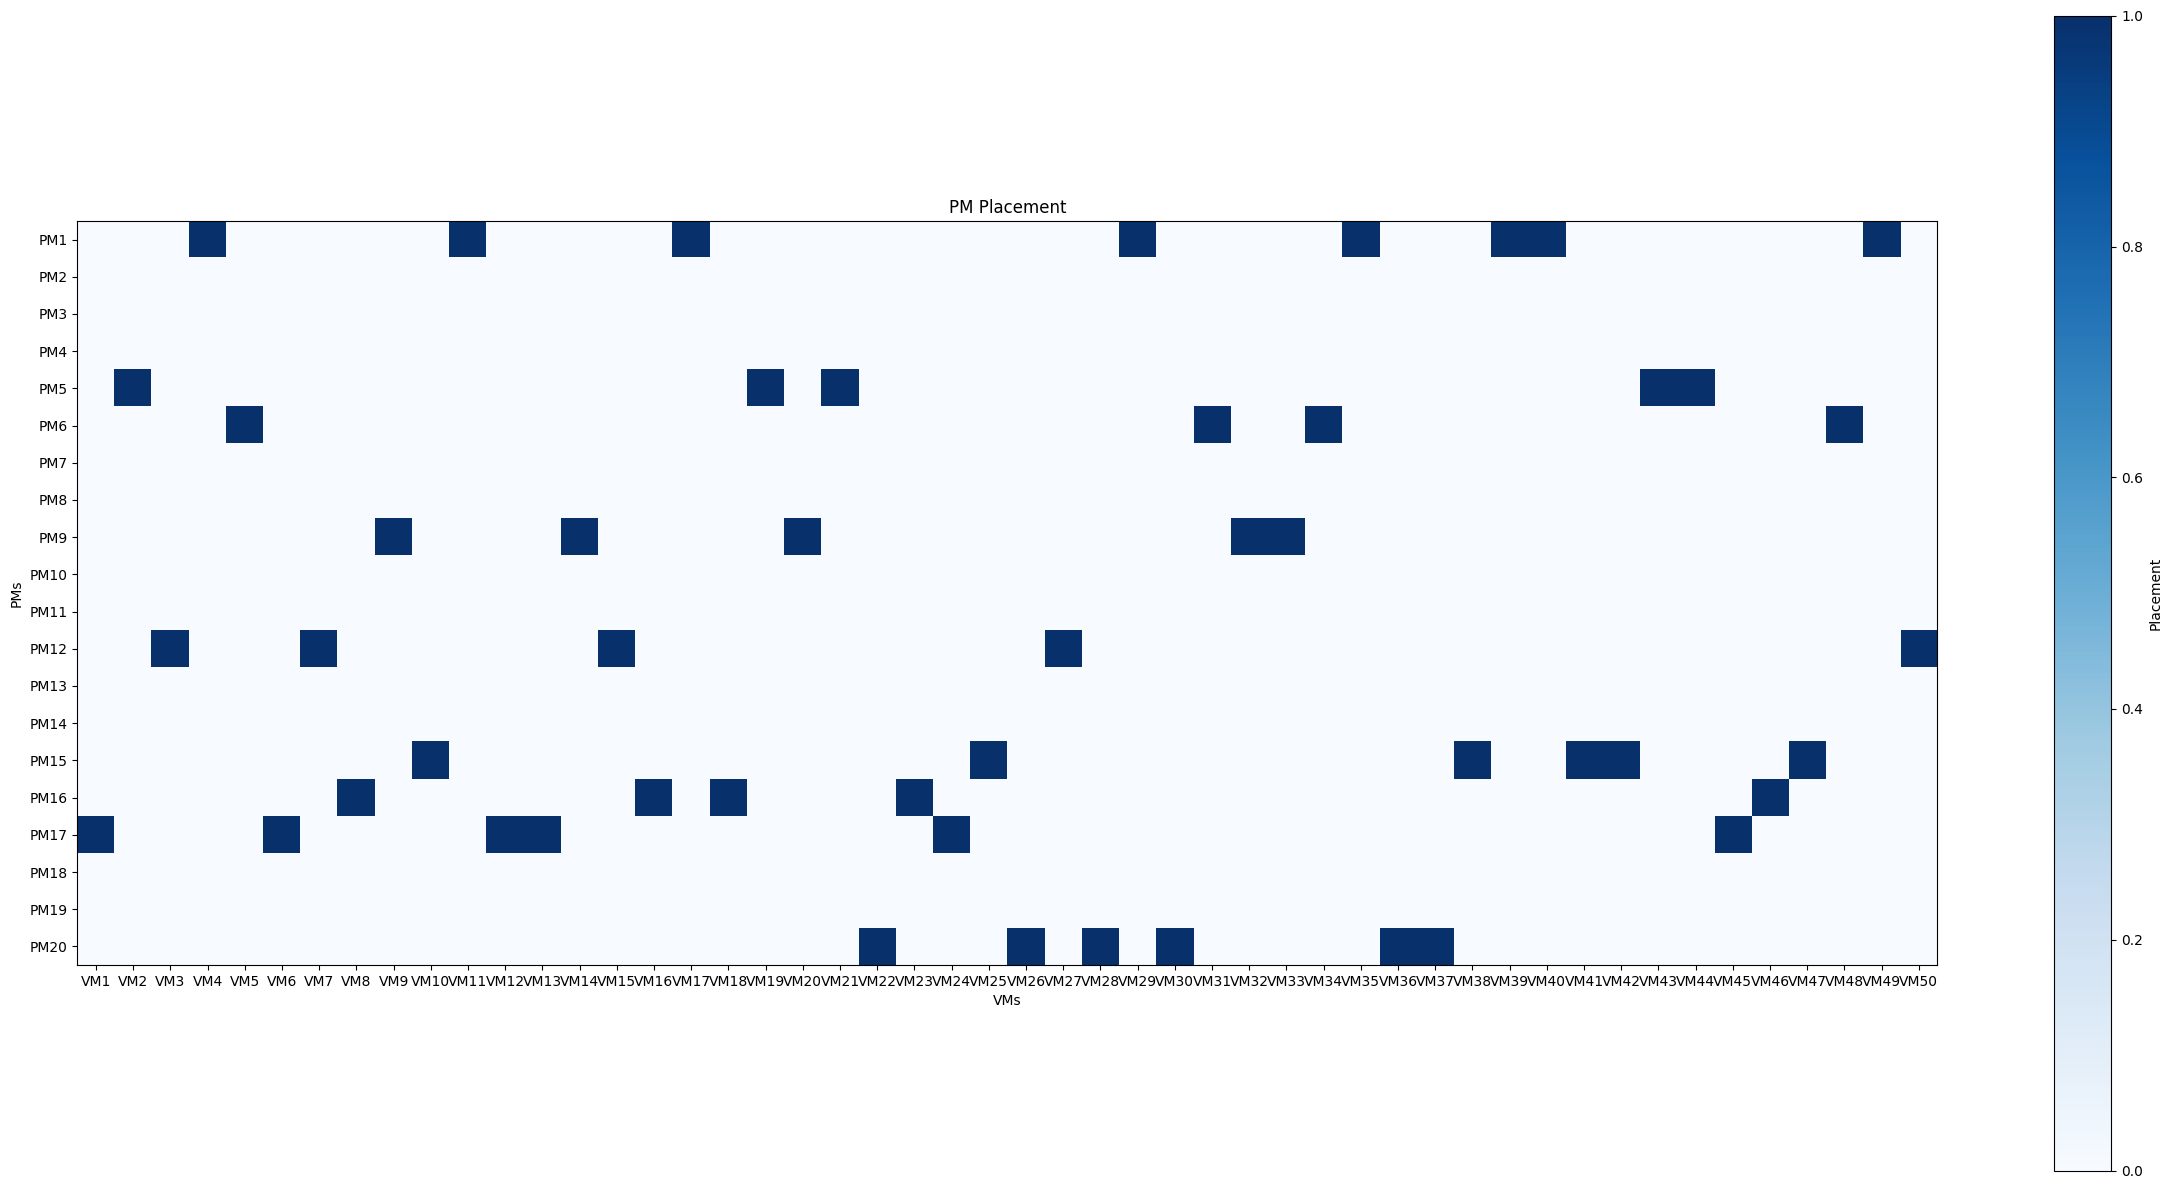

Use rate of each PM: {'PM1': 8.0, 'PM5': 5.0, 'PM6': 4.0, 'PM9': 5.0, 'PM12': 5.0, 'PM15': 6.0, 'PM16': 5.0, 'PM17': 6.0, 'PM20': 6.0}


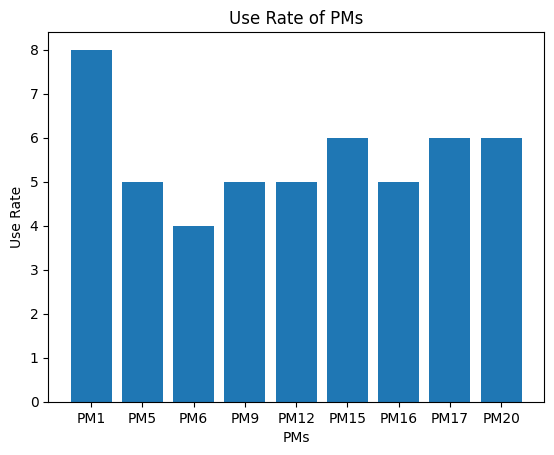

In [30]:
# Generate random data for the VM Placement problem
import random
random.seed(1977)
n = 50
m = 20
vms = {f'VM{i}': {'CPU': random.randint(1, 5), 'RAM': random.randint(1, 10), 'Disk': random.randint(1, 20)} for i in range(1, n+1)}
pms = {f'PM{i}': {'CPU': random.randint(10, 20), 'RAM': random.randint(20, 40), 'Disk': random.randint(40, 80), 'Power': random.randint(50, 200)} for i in range(1,m+1)}

# Define the optimization model
model = gp.Model('VM Placement')

# Define the decision variables
x = model.addVars(vms, pms, vtype=GRB.BINARY, name='x')
y = model.addVars(pms, vtype=GRB.BINARY, name='y')

# Define the objective function
model.setObjective(gp.quicksum(y[j] * pms[j]['Power'] for j in pms), GRB.MINIMIZE)

# Constraints
model.addConstrs((gp.quicksum(x[i, j] for j in pms) == 1 for i in vms), name='VM')
model.addConstrs((gp.quicksum(vms[i]['CPU'] * x[i, j] for i in vms) <= pms[j]['CPU'] * y[j] for j in pms), name='CPU')
model.addConstrs((gp.quicksum(vms[i]['RAM'] * x[i, j] for i in vms) <= pms[j]['RAM'] * y[j] for j in pms), name='RAM')
model.addConstrs((gp.quicksum(vms[i]['Disk'] * x[i, j] for i in vms) <= pms[j]['Disk'] * y[j] for j in pms), name='Disk')

# Write the model to a file
model.write("VM_Placement_Random.lp")
# Optimize the model
model.optimize()

# Print the optimal solution
if model.status == GRB.OPTIMAL:
    print('The optimal solution has total power consumption:', model.objVal)
    for j in pms:
        if y[j].x > 0.5:
            print(f'PM {j} is used with power consumption {pms[j]["Power"]}')
            for i in vms:
                if x[i, j].x > 0.5:
                    print(f'VM {i} is placed on PM {j}')
    # Visualize the optimal solution
    placement = pd.DataFrame(0, index=pms, columns=vms)
    for i in vms:
        for j in pms:
            placement.at[j, i] = x[i, j].x

    plt.figure(figsize=(30, 15))
    plt.imshow(placement, cmap='Blues', interpolation='nearest')
    plt.xticks(range(len(vms)), vms.keys())
    plt.yticks(range(len(pms)), pms.keys())
    plt.xlabel('VMs')
    plt.ylabel('PMs')
    plt.title('PM Placement')
    plt.colorbar(label='Placement')
    plt.show()

    # Save the optimal solution to a CSV file
    placement.to_csv('VM_Placement_Random.csv')

    # Calculate and Visualize the use rate of each PM
    use_rate = {j: sum(x[i, j].x for i in vms) / y[j].x for j in pms if y[j].x > 0.5}
    print('Use rate of each PM:', use_rate)
    plt.bar(use_rate.keys(), use_rate.values())
    plt.xlabel('PMs')
    plt.ylabel('Use Rate')
    plt.title('Use Rate of PMs')
    plt.show()

else:
    print('No solution found')